In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sn
import random
from scipy import spatial
from collections import Counter
from sklearn.preprocessing import normalize
import gensim
from scipy.cluster.hierarchy import dendrogram
from scipy.stats import chisquare, chi2_contingency

np.seterr(all='raise')
# bc = BertClient(ip="internal.kixlab.org", port=8888, port_out=8889)


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
queries = pd.read_csv('new_logs.csv', index_col="idx", dtype={"AnonID": "Int64", "Query": "string", "QueryTime": "string", "ItemRank": "Int32", "ClickURL": "string", "Type": "string", "SessionNum": "Int32"}, keep_default_na=False, na_values=[""])

queries = queries.loc[queries['Query'] != '-']


In [3]:
group_by_sessions = queries.groupby('AnonID', sort=False, as_index=False)
qqq = group_by_sessions.max(numeric_only=True)
newIDs = qqq.loc[qqq['SessionNum'] >= 19]
# print(newIDs)
# print(newIDs["AnonID"])



In [4]:
def compute_edit_distance(queryA, queryB):
  a = len(queryA)
  b = len(queryB)
  dp = [[0 for x in range(b + 1)] for x in range(a + 1)]

  for i in range(a + 1):
    for j in range(b + 1):
      if i == 0:
        dp[i][j] = j
      elif j == 0:
        dp[i][j] = i
      elif queryA[i - 1] == queryB[j - 1]:
        dp[i][j] = dp[i-1][j-1]
      else:
        dp[i][j] = 1 + min(dp[i-1][j-1], dp[i][j-1], dp[i-1][j])

  return dp[a][b]

def compute_semantic_similarity(old_query, new_query):
  # embeddings = bc.encode([old_query, new_query])
  # return 1 - spatial.distance.cosine(embeddings[0], embeddings[1])

  return 1

def is_new_query(old_query, new_query):
  # compute semantic similarities and edit distances to gauge query similarities
  if compute_edit_distance(old_query, new_query) < 5: #
    return False

  if compute_semantic_similarity(old_query, new_query) > 0.7:
    return False
    
  return True

def flatten_logs(logs_dataframe):
  previous_row = None
  previous_query = ''
  flattened = []
  
  for idx, row in logs_dataframe.iterrows():
    if previous_row is None: # Every logstream starts with a query
      print(row)
      flattened.append("NewQuery")
      previous_row = row
      previous_query = row['Query']
      
      continue

    if row["Type"] == "Query":
      if is_new_query(previous_query, row['Query']):
        flattened.append("NewQuery")
      else:
        flattened.append("RefinedQuery")
    elif row["Type"] == "Click":
      if row["ItemRank"] == 1:
        flattened.append("Click1")
      elif row["ItemRank"] >= 2 and row["ItemRank"] < 6:
        flattened.append("Click2-5")
      elif row["ItemRank"] >= 6 and row["ItemRank"] < 10:
        flattened.append("Click6-10")
      else:
        flattened.append("Click11+")
    elif row["Type"] == "NextPage":
      flattened.append("NextPage")

  return flattened


In [5]:

def create_n_gram(sequence, n = 5):
  ngram = []
  length = len(sequence)
  if length < n:
    filled = sequence + ["Empty" for i in range(n - length)]
    ngram.append(tuple(filled))

  else:
    for i in range(length - n + 1):
      ngram.append(tuple(sequence[i:i+n]))

  return ngram


In [6]:

def compute_distance(n_gram_1, n_gram_2, concatenated_set):
  counter_ngram_1 = Counter(n_gram_1)
  counter_ngram_2 = Counter(n_gram_2)


  n_gram_vec_1 = np.asarray([(counter_ngram_1[n]) for n in concatenated_set])
  n_gram_vec_1 = n_gram_vec_1 / np.linalg.norm(n_gram_vec_1)
  n_gram_vec_2 = np.asarray([(counter_ngram_2[n]) for n in concatenated_set])
  n_gram_vec_2 = n_gram_vec_2 / np.linalg.norm(n_gram_vec_2)

  distance = np.arccos((np.dot(n_gram_vec_1, n_gram_vec_2) / np.sqrt(np.dot(n_gram_vec_1, n_gram_vec_1) * np.dot(n_gram_vec_2, n_gram_vec_2)))) / np.pi

  return distance

def ngrams_to_vectors(n_gram_1, concatenated_set):
  counter_ngram_1 = Counter(n_gram_1)
  n_gram_vec_1 = np.asarray([(counter_ngram_1[n]) for n in concatenated_set])
  # n_gram_vec_1 = n_gram_vec_1 / np.linalg.norm(n_gram_vec_1)

  return n_gram_vec_1

In [7]:
group_by_sessions = queries.groupby(["AnonID", "SessionNum"])

tuples = []
# for idx, row in newIDs.iterrows():
#   tuples += [(row["AnonID"], i) for i in range(row["SessionNum"])]

## First, extract all tuples with appropriately long sessions

ssss = group_by_sessions.count()
ss = ssss[ssss["Query"] >= 5]

for idx, _ in ss.iterrows():
  tuples += [idx]

### Then, draw 5,000 samples

SAMPLE_SIZE = 5000

random.seed(0)

sample = random.sample(tuples, SAMPLE_SIZE)



In [9]:

sequences = []
ngrams = []

for s in sample:
  g = group_by_sessions.get_group(s)
  flattened_log = flatten_logs(g)
  ngram = create_n_gram(flattened_log, n = 3)
  sequences.append(flattened_log)
  ngrams.append(ngram)

concat_set = list(set([ngram for n in ngrams for ngram in n]))


AnonID                    8730322
Query           off road go carts
QueryTime     2006-05-25 11:53:36
Type                        Query
SessionNum                     78
ItemRank                     <NA>
ClickURL                     <NA>
Name: 2019409, dtype: object
AnonID                                   10549075
Query         contra costa county human resources
QueryTime                     2006-03-21 16:46:44
Type                                        Query
SessionNum                                      4
ItemRank                                     <NA>
ClickURL                                     <NA>
Name: 2377223, dtype: object
AnonID                      666115
Query         wholesale flip flops
QueryTime      2006-05-19 21:56:51
Type                         Query
SessionNum                     112
ItemRank                      <NA>
ClickURL                      <NA>
Name: 897504, dtype: object
AnonID                    4428397
Query                      boneme
QueryTime    

In [46]:
def normalize_vectors(vectors):
  average_vector = np.average(vectors, axis=0)
  normalized_vectors = vectors #  - average_vector

  normalized_vectors = normalize(normalized_vectors, axis = 1)

  return normalized_vectors

def compute_polar_distance(n_gram_vec_1, n_gram_vec_2):
  distance = np.arccos((np.dot(n_gram_vec_1, n_gram_vec_2) / np.sqrt(np.dot(n_gram_vec_1, n_gram_vec_1) * np.dot(n_gram_vec_2, n_gram_vec_2)))) / np.pi
  return distance


def divisive_clustering(ngrams, concat_set, n_clusters):
  vectors = np.asarray([ngrams_to_vectors(ngram, concatenated_set=concat_set) for ngram in ngrams])

  clusters = np.asarray([1 for vector in vectors])
  distinguishing_features = {1: []}

  for i in range(n_clusters):
    divide(vectors, clusters, distinguishing_features, i+1)

  return clusters, distinguishing_features

def divide(vectors, clusters, distinguishing_features, cluster_id):
  selected_vector_idx = np.where(clusters == cluster_id)[0]
  # print(selected_vector_idx)
  selected_vector_size = len(selected_vector_idx)
  selected_vectors = np.copy(vectors[selected_vector_idx])
  selected_vectors[:, distinguishing_features[cluster_id]] = 0
  # print(distinguishing_features[cluster_id])

  distances = np.zeros((selected_vector_size, selected_vector_size))

  # print(distances.size)

  normalized_vectors = normalize_vectors(selected_vectors)

  for i in range(selected_vector_size):
    for j in range(i):
      distances[i, j] = compute_polar_distance(normalized_vectors[i], normalized_vectors[j]) #compute_distance(ngrams[i], ngrams[j], concatenated_set=concat_set)
      distances[j, i] = distances[i, j]

  # splinters = [np.argmax(np.sum(distances, axis = 0))]

  mask = np.ones(selected_vector_size, bool)

  mask[np.argmax(np.average(distances, axis = 1))] = False
  # print(np.argmax(np.average(distances, axis = 1)))
  while True:
    avg_distance_to_splinters = np.average(distances[:, ~mask], axis=1)

    avg_distance_within = np.average(distances[:, mask], axis=1)

    diff = avg_distance_to_splinters - avg_distance_within

    diff[~mask] = np.Inf
    candidate = np.argmin(diff)
    # print(candidate, diff[candidate], mask[candidate])

    if diff[candidate] < 0:
      mask[candidate] = False
    else:
      break

  splinter_cluster = selected_vectors[~mask]
  remaining_cluster = selected_vectors[mask]

  # contingency_table = np.asarray([np.sum(splinter_cluster, axis=0), np.sum(remaining_cluster, axis=0)])

  max_chisq = 0
  max_idx = 0
  for i in range(vectors.shape[1]):
    if i in distinguishing_features[cluster_id]:
      continue
    cont = np.asarray([[np.where(splinter_cluster[:, i] > 0)[0].size, np.where(splinter_cluster[:, i] <= 0)[0].size],
    [np.where(remaining_cluster[:, i] > 0)[0].size, np.where(remaining_cluster[:, i] <= 0)[0].size]])
    if not np.all(cont):
      continue
    # print(cont)
    chi2, p, dof, ex = chi2_contingency(cont)
    print("Chi sq for cluster %d, component %d: %d", cluster_id, i, chi2)
    if chi2 > max_chisq:
      max_chisq = chi2
      max_idx = i

  in_cluster_id = 2 * cluster_id
  out_cluster_id = 2 * cluster_id + 1

  distinguishing_features[in_cluster_id] = distinguishing_features[cluster_id] + [max_idx]
  distinguishing_features[out_cluster_id] = distinguishing_features[cluster_id] + [max_idx]

  in_clusters = selected_vector_idx[mask]
  out_clusters = selected_vector_idx[~mask]

  clusters[in_clusters] = in_cluster_id
  clusters[out_clusters] = out_cluster_id



In [11]:


vectors = np.asarray([ngrams_to_vectors(ngram, concatenated_set=concat_set) for ngram in ngrams])

normalized_vectors = normalize_vectors(vectors)

distances = np.zeros((SAMPLE_SIZE, SAMPLE_SIZE))

for i in range(SAMPLE_SIZE):
  for j in range(i):
    distances[i, j] = compute_polar_distance(normalized_vectors[i], normalized_vectors[j]) #compute_distance(ngrams[i], ngrams[j], concatenated_set=concat_set)
    distances[j, i] = distances[i, j]



In [47]:
clusters,distinguishing_features = divisive_clustering(ngrams, concat_set, 16)

[   0    1    2 ... 4997 4998 4999]
[]
25000000
4528
2974 -0.12762232436472798 True
463 -0.09599625549517166 True
4524 -0.13339030559130954 True
42 -0.14025177967399582 True
318 -0.12479115667061252 True
1995 -0.09471342729196114 True
4921 -0.12691511556721013 True
1741 -0.1514109229740364 True
2568 -0.1647674985422034 True
551 -0.1767893613155469 True
2708 -0.18093326750247163 True
1299 -0.19313802355490362 True
3353 -0.19643249215284098 True
1669 -0.20150540247035903 True
1022 -0.2054515861649306 True
3388 -0.21173749540112885 True
4481 -0.2203827807811622 True
731 -0.2268896051488793 True
3329 -0.2267419995292848 True
1180 -0.22950906887577677 True
3999 -0.23245672582534255 True
920 -0.2370166407558276 True
3197 -0.2390382608612348 True
2074 -0.24258443171609417 True
2910 -0.2444661730941903 True
3030 -0.25392678992061724 True
379 -0.24833128545529706 True
4628 -0.2522894864109636 True
3936 -0.2496540330668765 True
2613 -0.24980420195650005 True
97 -0.2520320407808582 True
3771 -0.2

In [54]:

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA

cc = AgglomerativeClustering(n_clusters = 12, affinity = 'precomputed', compute_full_tree = True, linkage='average')

labels = cc.fit_predict(distances)
print(labels)


[2 2 0 ... 5 9 0]


[0.08911059 0.07799271]


<AxesSubplot:>

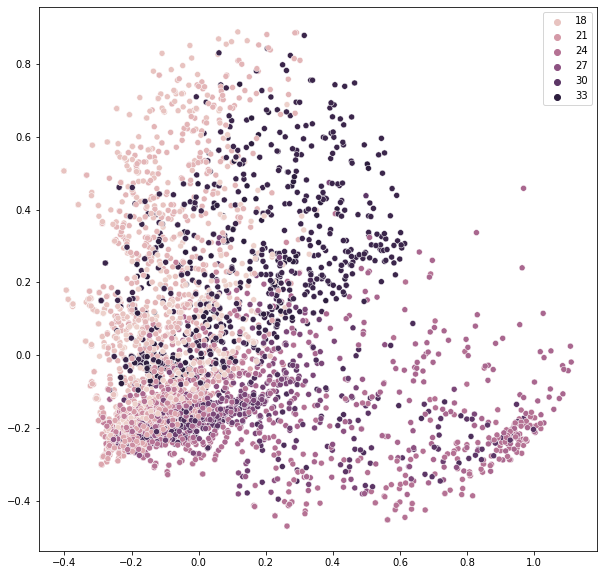

In [56]:

pca = PCA(n_components=2)

pca_result = np.ascontiguousarray(pca.fit_transform(normalized_vectors))

print(pca.explained_variance_ratio_)


plt.figure(figsize= (10, 10))

sn.scatterplot(x = pca_result[:, 0], y = pca_result[:, 1], hue = clusters)


In [16]:
from scipy.cluster.hierarchy import linkage, fclusterdata

# aaa = fclusterdata(normalized_vectors, t = 0.2, criterion='distance', metric=compute_polar_distance)
aaa = fclusterdata(normalized_vectors, t = 2, criterion='maxclust', metric=compute_polar_distance)

# dendrogram(aaa,  p = 8, truncate_mode='level')



<AxesSubplot:>

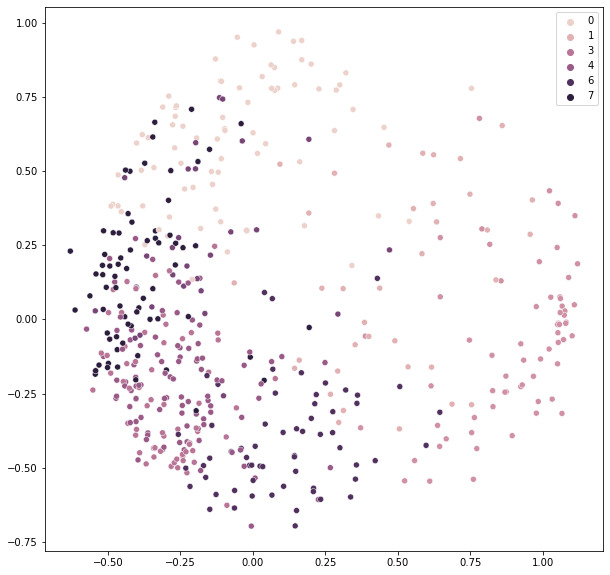

In [99]:

kk = KMeans(n_clusters = 8)

kk_labels = kk.fit_predict(normalized_vectors)

plt.figure(figsize=(10, 10))
sn.scatterplot(x = pca_result[:, 0], y = pca_result[:, 1], hue = kk_labels)






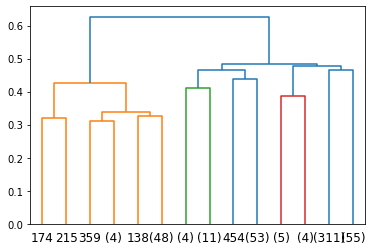

<Figure size 2160x2160 with 0 Axes>

In [12]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plot_dendrogram(cc, truncate_mode = 'level', p=3)
plt.figure(figsize = (30, 30))
plt.show()

In [13]:
print(np.max(distances), np.min(distances))

print(cc.children_)

0.8374888984730559 0.0
[[208 293]
 [113 465]
 [187 448]
 [354 455]
 [128 500]
 [349 435]
 [ 37 239]
 [ 34 294]
 [188 507]
 [501 506]
 [309 449]
 [369 508]
 [353 511]
 [393 510]
 [348 495]
 [283 381]
 [386 411]
 [504 509]
 [ 65 204]
 [176 298]
 [101 232]
 [252 452]
 [505 517]
 [ 11 515]
 [513 518]
 [  2 514]
 [164 456]
 [ 69 512]
 [412 519]
 [ 61 437]
 [133 285]
 [396 523]
 [525 528]
 [ 76 524]
 [ 36 153]
 [ 87 189]
 [383 529]
 [212 421]
 [182 256]
 [522 527]
 [361 376]
 [ 63 262]
 [312 380]
 [428 458]
 [  6 185]
 [160 397]
 [532 533]
 [109 536]
 [236 282]
 [ 19 534]
 [ 16 391]
 [103 199]
 [ 29 241]
 [152 492]
 [ 26 539]
 [ 96 168]
 [526 541]
 [137 503]
 [538 554]
 [147 521]
 [ 98 148]
 [327 367]
 [502 547]
 [535 540]
 [227 544]
 [ 47  81]
 [ 58 447]
 [462 499]
 [ 54 228]
 [178 387]
 [316 373]
 [ 41 531]
 [516 537]
 [ 46 196]
 [221 366]
 [ 59  77]
 [489 561]
 [410 546]
 [377 543]
 [ 45 555]
 [ 40 372]
 [552 559]
 [121 403]
 [186 238]
 [167 491]
 [169 553]
 [  8 100]
 [520 568]
 [ 73 563

In [58]:
with open('n-gram-divisive.txt', 'w') as f:
  for i in range(SAMPLE_SIZE):
    label_agg = int(labels[i])
    label_scipy = 0 # int(aaa[i])
    label_divisive = str(clusters[i])
    userid = str(sample[i][0])
    group = str(sample[i][1])
    g = group_by_sessions.get_group(sample[i])
    previous_query = g.iloc[0]['Query']
    row = str(label_agg) + ',' + str(label_scipy) + ',' + label_divisive + ',' + '+'.join(sequences[i]) + ',' + userid + ',' + group + ',' + previous_query + '\n'
    f.write(row)
  
  

<AxesSubplot:>

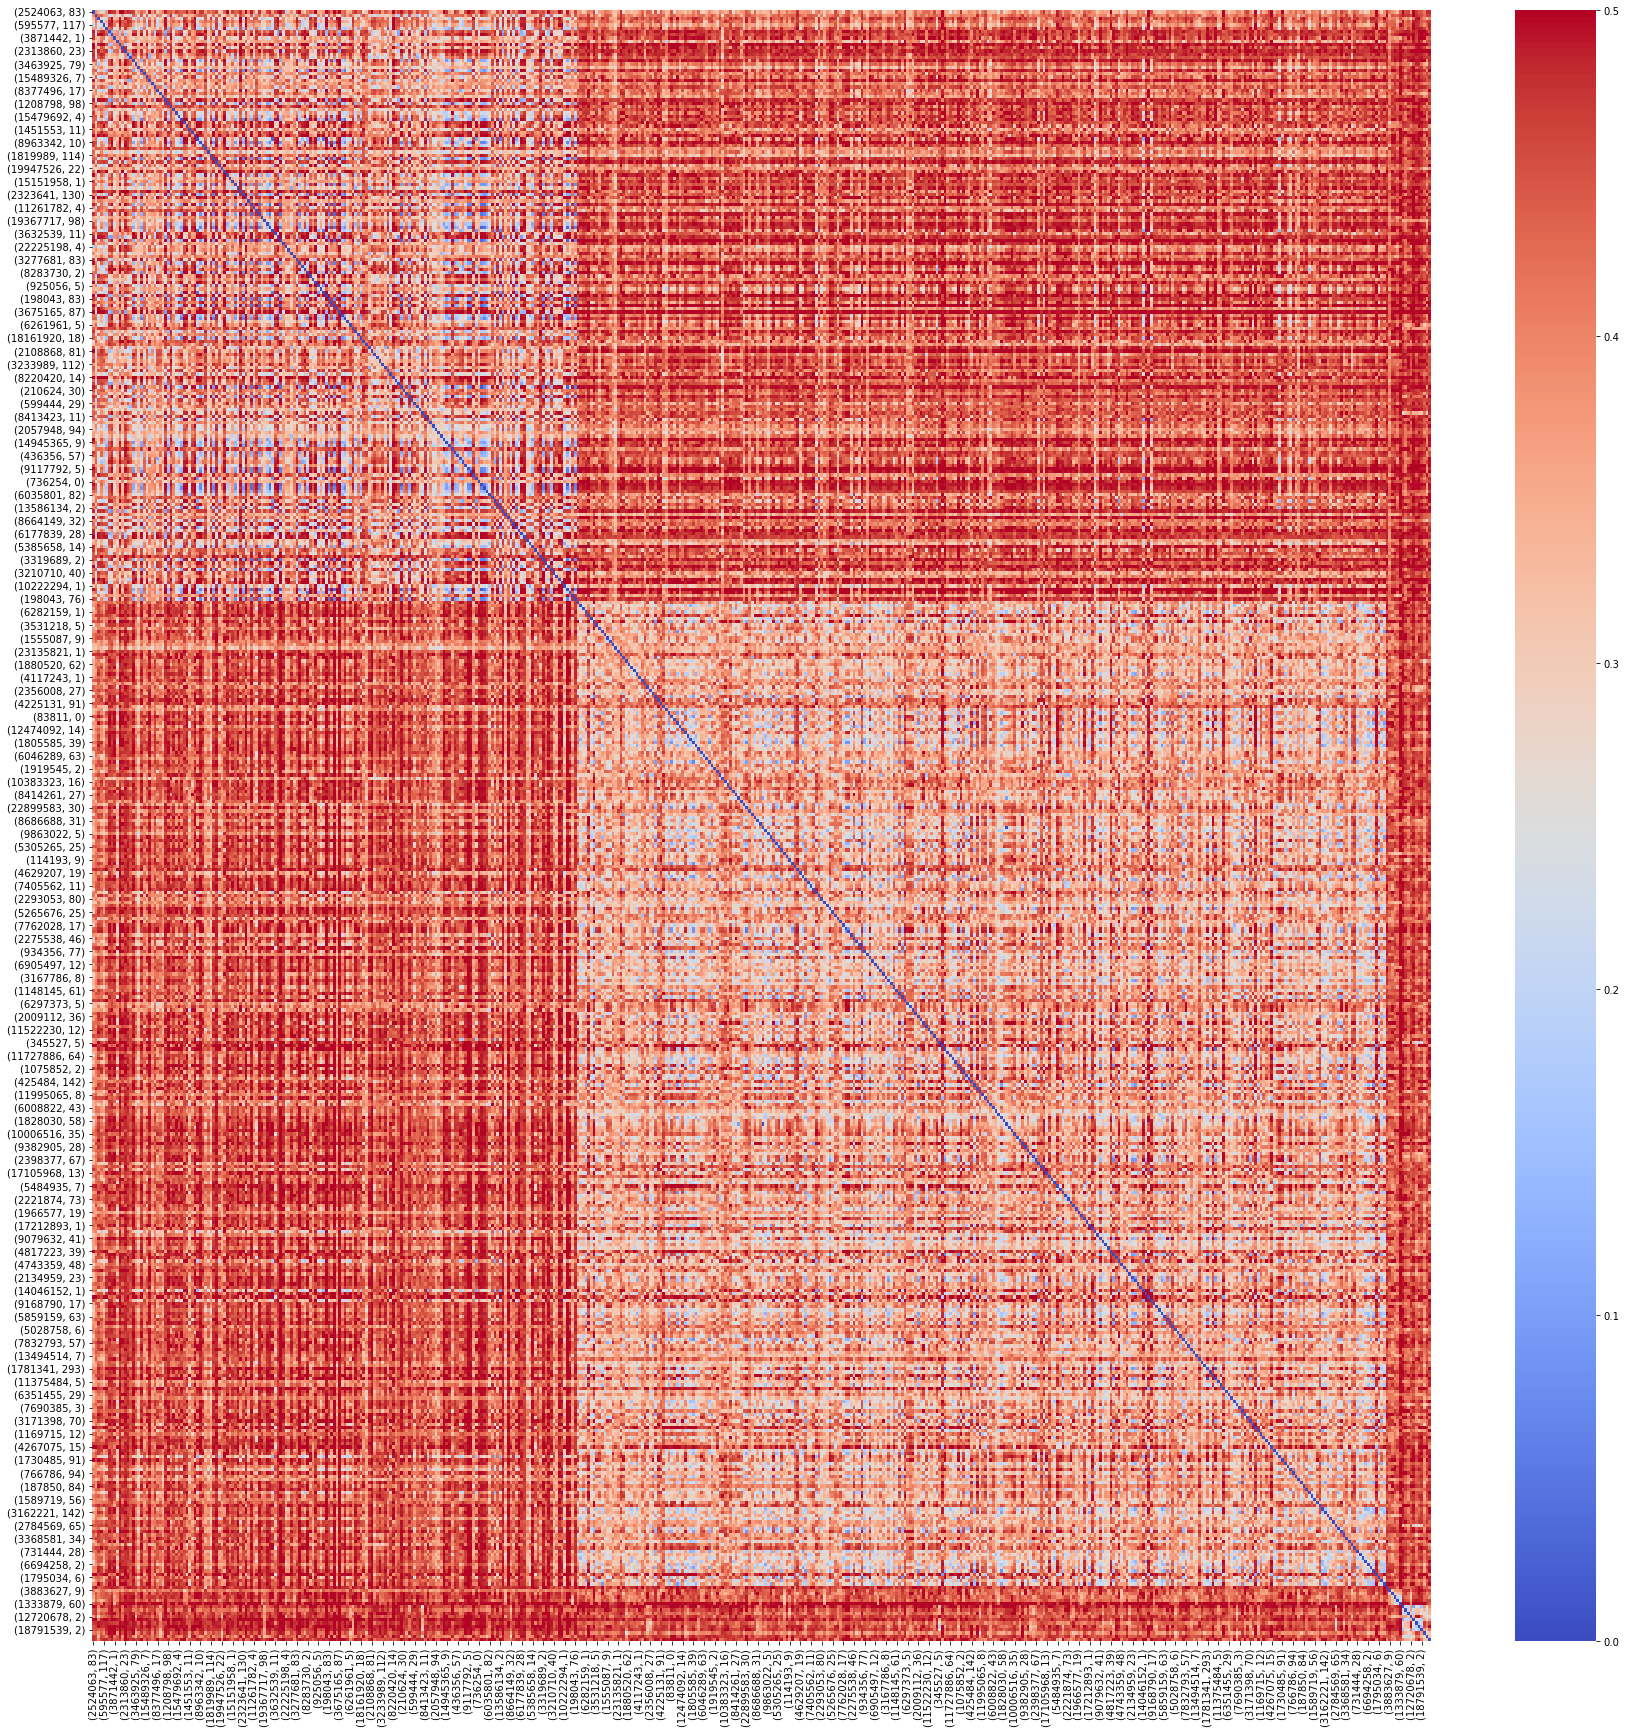

In [81]:
from sklearn.cluster import AgglomerativeClustering

c = AgglomerativeClustering(n_clusters = 5, affinity="precomputed", compute_full_tree = True, linkage="average")

labels = c.fit_predict(distances)

idx = np.argsort(labels)
sorted_sample = [sample[x] for x in idx]

distances_df = pd.DataFrame(data=distances, index=labels, columns = labels).sort_index(axis=0).sort_index(axis=1)
distances_df.set_axis(sorted_sample, axis="index", inplace=True)
distances_df.set_axis(sorted_sample, axis="columns", inplace=True)

plt.figure(figsize= (30, 30))

sn.heatmap(distances_df, cmap="coolwarm")




In [53]:
## Trash, scratch cell

print(clusters)
print(distinguishing_features)
cc = np.asarray(concat_set)
print(cc[distinguishing_features[30]])

[22 18 19 ... 24 29 18]
{1: [], 2: [84], 3: [84], 4: [84, 174], 5: [84, 174], 6: [84, 4], 7: [84, 4], 8: [84, 174, 165], 9: [84, 174, 165], 10: [84, 174, 108], 11: [84, 174, 108], 12: [84, 4, 111], 13: [84, 4, 111], 14: [84, 4, 137], 15: [84, 4, 137], 16: [84, 174, 165, 195], 17: [84, 174, 165, 195], 18: [84, 174, 165, 236], 19: [84, 174, 165, 236], 20: [84, 174, 108, 210], 21: [84, 174, 108, 210], 22: [84, 174, 108, 18], 23: [84, 174, 108, 18], 24: [84, 4, 111, 8], 25: [84, 4, 111, 8], 26: [84, 4, 111, 104], 27: [84, 4, 111, 104], 28: [84, 4, 137, 77], 29: [84, 4, 137, 77], 30: [84, 4, 137, 65], 31: [84, 4, 137, 65], 32: [84, 174, 165, 195, 82], 33: [84, 174, 165, 195, 82]}
[['NextPage' 'NextPage' 'NextPage']
 ['NextPage' 'Click11+' 'Click11+']
 ['Click11+' 'Click11+' 'Click11+']
 ['Click11+' 'NextPage' 'Click11+']]
